In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
import matplotlib.pyplot as plt


2024-12-02 11:49:19.601304: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-02 11:49:19.871548: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-02 11:49:19.871604: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-02 11:49:19.900187: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 11:49:19.983916: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-02 11:49:19.985230: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
# Load the data
data = pd.read_csv('Control_vs_IPF_data.csv')

In [3]:
data.head()

,Unnamed: 0,RP11-34P13.3,RP11-34P13.7,RP11-34P13.14,FO538757.3,FO538757.2,AP006222.2,RP4-669L17.2,RP4-669L17.10,RP5-857K21.4,...,AC007325.1,AC007325.4,AC007325.2,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,Diagnosis
0,F00431_AGAGCTTGTAGAGGAA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,IPF
1,F01380_GATCTAGTCTTGCCGT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,IPF
2,F01391_AGTCTTTAGGTTACCT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.818575,0.0,0.0,0.0,0.0,0.0,0.0,IPF
3,F01391_ATCCACCAGGAGTCTG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,IPF
4,F01391_CTCGTCATCATCTGCC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.820563,0.0,0.0,0.0,0.0,0.0,0.0,IPF


In [4]:
def preprocess_gene_expression_data(data):
    # Remove the first column if it's an unnamed index
    if 'Unnamed: 0' in data.columns:
        data = data.drop('Unnamed: 0', axis=1)
    
    # Separate features and labels
    X = data.drop('Diagnosis', axis=1)
    y = data['Diagnosis']
    
    # Encode diagnoses
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Print unique diagnoses and their encoded values
    print("Diagnosis Encoding:")
    for original, encoded in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
        print(f"{original}: {encoded}")
    
    # Remove any non-numeric columns from features
    X = X.select_dtypes(include=[np.number])
    
    # Handle missing values
    X = X.fillna(X.mean())
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y_encoded, label_encoder, scaler

In [20]:
class GeneExpressionVAE(keras.Model):
    def __init__(self, input_dim, latent_dim=2, intermediate_dim=256, num_classes=6):
        super(GeneExpressionVAE, self).__init__()
        
        # Store dimensions
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.intermediate_dim = intermediate_dim
        self.num_classes = num_classes
        
        # Encoder Network
        self.encoder = keras.Sequential([
            keras.layers.InputLayer(input_shape=(self.input_dim,)),
            keras.layers.Dense(intermediate_dim, activation='relu'),
            keras.layers.BatchNormalization(),
            keras.layers.Dropout(0.3),
            keras.layers.Dense(intermediate_dim // 2, activation='relu'),
            keras.layers.BatchNormalization()
        ])
        
        # Latent Space Parameters
        self.z_mean = keras.layers.Dense(latent_dim)
        self.z_log_var = keras.layers.Dense(latent_dim)
        
        # Classifier Head
        self.classifier = keras.Sequential([
            keras.layers.Dense(64, activation='relu'),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(num_classes, activation='softmax')
        ])
        
        # Decoder Network
        self.decoder = keras.Sequential([
            keras.layers.InputLayer(input_shape=(latent_dim,)),
            keras.layers.Dense(intermediate_dim // 2, activation='relu'),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(intermediate_dim, activation='relu'),
            keras.layers.BatchNormalization()
        ])
        
        # Final decoder layer to reconstruct input
        self.reconstruction_layer = keras.layers.Dense(self.input_dim, activation='linear')
    
    def encode(self, x):
        h = self.encoder(x)
        z_mean = self.z_mean(h)
        z_log_var = self.z_log_var(h)
        return z_mean, z_log_var
    
    def reparameterize(self, z_mean, z_log_var):
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
    def decode(self, z):
        h = self.decoder(z)
        reconstructed = self.reconstruction_layer(h)
        return reconstructed
    
    def classify(self, z):
        return self.classifier(z)
    
    def call(self, inputs, training=False):
        # Encode
        z_mean, z_log_var = self.encode(inputs)
        
        # Reparameterization trick
        z = self.reparameterize(z_mean, z_log_var)
        
        # Reconstruct
        reconstructed = self.decode(z)
        
        if training:
            # Classify when training
            classification = self.classify(z)
            return reconstructed, z_mean, z_log_var, classification
        
        return reconstructed, z_mean, z_log_var

In [21]:
# Custom Loss Function
def vae_loss(x, x_recon, z_mean, z_log_var, y=None, y_pred=None, 
             reconstruction_weight=1.0, kl_weight=1.0, classification_weight=1.0):
    # Reconstruction Loss
    reconstruction_loss = tf.reduce_mean(tf.square(x - x_recon))
    
    # KL Divergence Loss
    kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    
    # Classification Loss
    classification_loss = 0
    if y is not None and y_pred is not None:
        classification_loss = tf.keras.losses.SparseCategoricalCrossentropy()(y, y_pred)
    
    # Weighted Total Loss
    total_loss = (reconstruction_weight * reconstruction_loss + 
                  kl_weight * kl_loss + 
                  classification_weight * classification_loss)
    
    return total_loss

In [22]:
 # Training Function
def train_vae(X_train, X_test, y_train, y_test, num_classes):
    # Model Hyperparameters
    latent_dim = 2
    intermediate_dim = 256
    epochs = 200
    batch_size = 32
    learning_rate = 1e-3
    
    # Create VAE Model
    vae = GeneExpressionVAE(
        input_dim=X_train.shape[1],
        latent_dim=latent_dim, 
        intermediate_dim=intermediate_dim, 
        num_classes=num_classes
    )
    
    # Optimizer
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    # Training Loop
    @tf.function
    def train_step(x, y):
        with tf.GradientTape() as tape:
            # Forward pass
            reconstructed, z_mean, z_log_var, classification = vae(x, training=True)
            
            # Compute loss
            loss = vae_loss(x, reconstructed, z_mean, z_log_var, y, classification)
        
        # Compute gradients
        gradients = tape.gradient(loss, vae.trainable_variables)
        optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
        
        return loss
    
    # Prepare Dataset
    train_dataset = tf.data.Dataset.from_tensor_slices(
        (tf.cast(X_train, tf.float32), tf.cast(y_train, tf.int32))
    ).shuffle(1000).batch(batch_size)
    
    # Training
    losses = []
    for epoch in range(epochs):
        epoch_losses = []
        for batch_x, batch_y in train_dataset:
            loss = train_step(batch_x, batch_y)
            epoch_losses.append(loss.numpy())
        
        avg_loss = np.mean(epoch_losses)
        losses.append(avg_loss)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}, Loss: {avg_loss}")
    
    # Latent Space Visualization
    _, z_mean, _ = vae(tf.cast(X_test, tf.float32))
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter)
    plt.title('VAE Latent Space Visualization')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.show()
    
    return vae, losses

In [8]:
# Preprocess data
X, y, label_encoder, scaler = preprocess_gene_expression_data(data)

Diagnosis Encoding:
Control: 0
IPF: 1
NSIP: 2
Unclassifiable ILD: 3
cHP: 4
sacroidosis: 5


2024-12-02 14:36:46.211005: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19311340256 exceeds 10% of free system memory.


Epoch 1, Loss: 2.3816730976104736
Epoch 11, Loss: 2.0407285690307617
Epoch 21, Loss: 1.9930989742279053
Epoch 31, Loss: 1.9676553010940552
Epoch 41, Loss: 1.963828206062317
Epoch 51, Loss: 1.9533830881118774
Epoch 61, Loss: 1.9384504556655884
Epoch 71, Loss: 1.9308860301971436
Epoch 81, Loss: 1.9280074834823608
Epoch 91, Loss: 1.9231845140457153
Epoch 101, Loss: 1.91869056224823
Epoch 111, Loss: 1.9151612520217896
Epoch 121, Loss: 1.9141321182250977
Epoch 131, Loss: 1.9148215055465698
Epoch 141, Loss: 1.9082157611846924
Epoch 151, Loss: 1.9083926677703857
Epoch 161, Loss: 1.9078000783920288
Epoch 171, Loss: 1.9020265340805054
Epoch 181, Loss: 1.9031342267990112
Epoch 191, Loss: 1.903559684753418


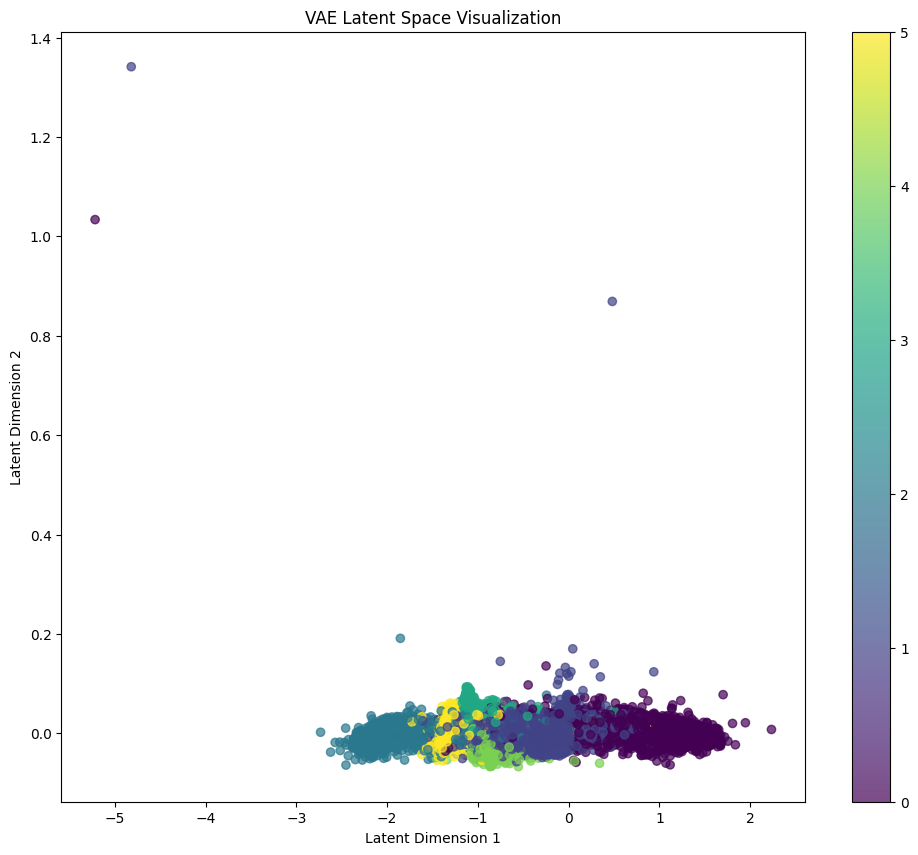

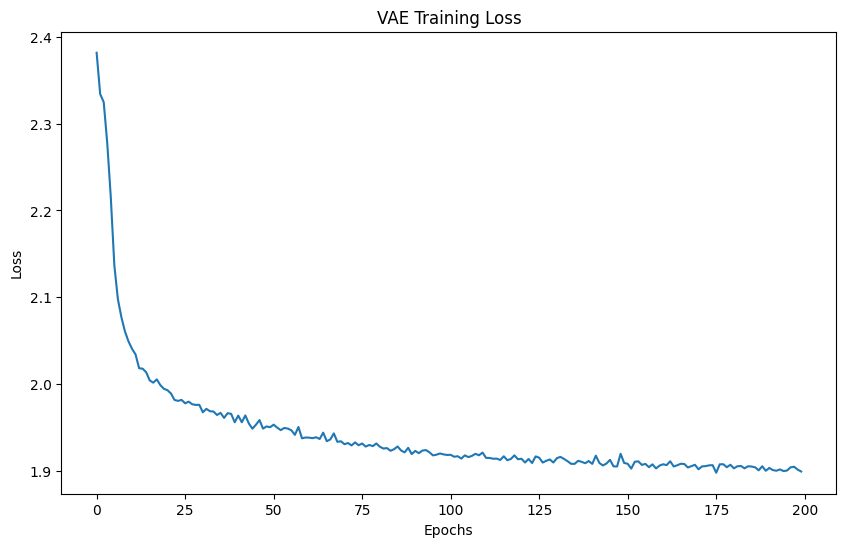

In [23]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train VAE
vae, losses = train_vae(
    X_train, X_test, y_train, y_test, 
    num_classes=len(np.unique(y))
)


# Plot Training Loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('VAE Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [26]:

# Reconstruction Loss
reconstructed, _, _= vae(tf.cast(X_test, tf.float32))
reconstruction_loss = tf.reduce_mean(tf.square(tf.cast(X_test, tf.float32) - reconstructed))
print(f"Reconstruction Loss: {reconstruction_loss.numpy()}")

Reconstruction Loss: 0.9961482882499695


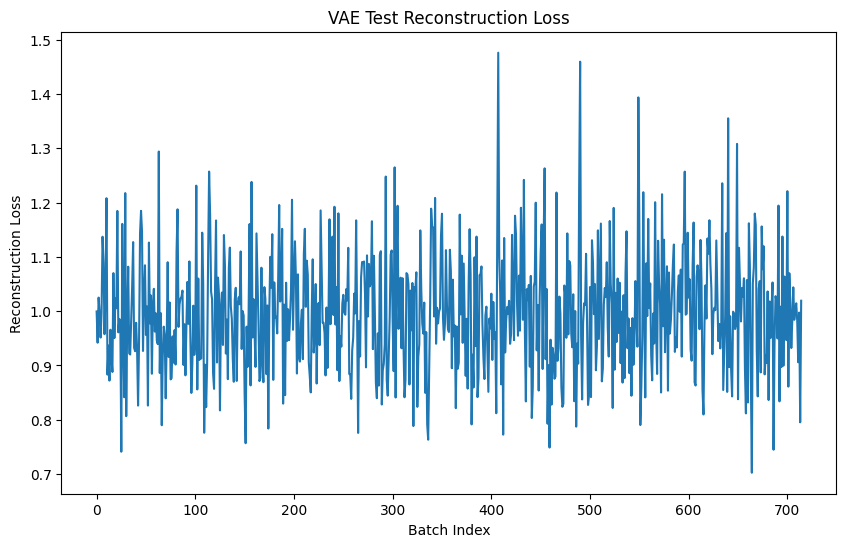

In [27]:
losses = []
for i in range(0, len(X_test), 32):
    x = tf.cast(X_test[i:i+32], tf.float32)
    x_recon, _, _ = vae(x)
    loss = tf.reduce_mean(tf.square(x - x_recon))
    losses.append(loss.numpy())

plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('VAE Test Reconstruction Loss')
plt.xlabel('Batch Index')
plt.ylabel('Reconstruction Loss')
plt.show()
